# Model Building
***Aim: How can the area burned by a Wildfire be estimated using salient features of the location (on the particular day)?*** 

*Steps*
* 1) Show through quick research that time duration does not affect the area burned (Chi-test, correlation & ...)
* 2) Show that exponential model does not work in estimating the burned area? (Explain directly, using graphs)
* 3) Control Rate explainataion and working (Small graphs, iteration, higher than 0.25)?
* 4) Approximation of the Control Rates using the formula and predicting for our California Dataset. 
* 5) Salient features for the given California Dataset
* 6) Make a preliminary - check the error - assess that feature importances
* 7) Remove the features which are creating noise - create a refined model - check for error
* 8) Show the improvement after feature selection (64%)
* 9) Use the control rate to predict AcresBurned
* 10) Evaluation of the process, Strengths, limitations, future applications and further scope

In [1]:
# Import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
import datetime
from random import choices

# Sklearn imports 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDRegressor
# Establishing defaults 
sns.set_style("white")

### Utility Functions

In [2]:
def sorted_results(cv_results, reverse = True):
    """
    This function sorts the cv_results test score in descending order by default but can be changed by calling 
    reverse = False
    """
    test_scores = cv_results["mean_test_score"]
    indices = np.argsort(test_scores)[-1::-1]
    sorted_test_score = test_scores[indices]
    cv_params = cv_results["params"]
    return sorted_test_score, [cv_params[i] for i in indices]
    

def display_scores(results, reverse = True):
    """
    This function displays the sorted results and the parameters in the required order 
    """
    cv_results = results.cv_results_
    test_scores, params = sorted_results(cv_results, reverse = reverse)
    print("{0:5} {1}".format("SCORE : ", "PARAMS"))
    print("*"*100)
    for score, params in zip(test_scores, params):
        print("{0:5} : {1:}".format(score, params))
    print("*"*100)

In [3]:
def rate_control_model(n_epochs, control_prob):
    active_places = np.array([[0, 0]])
    choice_array = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
    for i in range(n_epochs):
        # Fire Spread
        length = len(active_places)
        spread = np.array(choices(choice_array,k=length))
        new_places = active_places+spread
        active_places = np.append(active_places, new_places, axis = 0)
        # Fire control 
        length = len(active_places)
        indices = np.ones(length, dtype = np.bool)
        control_number = round(control_prob*length)
        if control_number > 0:
            indices[:control_number] = False
            indices = np.random.permutation(indices)
        active_places = active_places[indices]
    return active_places

In [4]:
def calc_turns(n_t, n_prob):
    current = 1
    for i in range(n_t):
        current = round(2*current*(1-n_prob))
    return current

In [5]:
def acres_to_control_rates(acres_array):
    """This function is built using logger pro and predicts the control rates
    given acres burned"""
    # COntrols
    A = 0.2933
    C = 0.0024
    B = -0.0097
    return A*np.exp(-C*acres_array)+B

In [6]:
source = 'images/'

## Set-Up

In [7]:
# Loading data
smallfires = pd.read_csv("data/SmallFires.csv")
smallfires.head()

,Unnamed: 0,AcresBurned,ArchiveYear,CrewsInvolved,Dozers,Engines,Fatalities,Featured,Final,Helicopters,Injuries,Latitude,Longitude,MajorIncident,Name,PersonnelInvolved,Started,UniqueId,Updated,Duration
0,15,3505.0,2013,8.0,NaN,5.0,NaN,False,True,NaN,6.0,38.816700,-122.849800,True,McCabe Fire,188.0,2013-11-22 02:04:00+00:00,b4bc1480-cbb8-4ef2-8d5f-88a496d21d10,2013-11-27 18:15:00+00:00,136.183333
1,16,3166.0,2013,36.0,5.0,62.0,NaN,False,True,5.0,2.0,34.288877,-116.941311,True,Summit Fire,726.0,2013-05-01 12:38:00+00:00,a1b14be5-a8cf-4e40-8588-96becf4c5879,2013-05-04 18:30:00+00:00,77.866667
2,17,3111.0,2013,8.0,5.0,3.0,NaN,False,True,NaN,NaN,37.907570,-121.882582,True,Morgan Fire,231.0,2013-09-08 13:08:00+00:00,e33b2d80-7fec-4470-9e79-440d349b0d95,2013-09-14 17:30:00+00:00,148.366667
3,18,2781.0,2013,33.0,25.0,73.0,NaN,False,True,25.0,5.0,33.121110,-116.525790,True,San Felipe Fire,911.0,2013-05-23 12:20:00+00:00,859479e3-918c-42c6-bb74-5fdc17930a16,2013-05-26 17:45:00+00:00,77.416667
4,19,2462.0,2013,33.0,28.0,95.0,NaN,False,True,20.0,5.0,39.446268,-121.382360,True,Swedes Fire,1484.0,2013-08-16 16:37:00+00:00,0758e1c0-95ea-47e7-b5c1-5f3ea96bc664,2013-08-22 18:00:00+00:00,145.383333


In [8]:
# Required 
columns = ["Latitude", "Longitude", "Duration", "AcresBurned", "Started"]
smallfires = smallfires.loc[:, columns]
smallfires.head()

,Latitude,Longitude,Duration,AcresBurned,Started
0,38.816700,-122.849800,136.183333,3505.0,2013-11-22 02:04:00+00:00
1,34.288877,-116.941311,77.866667,3166.0,2013-05-01 12:38:00+00:00
2,37.907570,-121.882582,148.366667,3111.0,2013-09-08 13:08:00+00:00
3,33.121110,-116.525790,77.416667,2781.0,2013-05-23 12:20:00+00:00
4,39.446268,-121.382360,145.383333,2462.0,2013-08-16 16:37:00+00:00


In [9]:
# Loading the data
# The data is stored in a csv file with an index
# which starts at 0 on the day 1st January, 2013
zero_date = datetime.date(2013, 1, 1)
smallfires["Started"] = pd.to_datetime(smallfires["Started"])
smallfires["Date"] = smallfires["Started"].dt.date

smallfires["DateIndex"] = (smallfires["Date"]- zero_date).dt.days 

In [10]:
smallfires.head()

,Latitude,Longitude,Duration,AcresBurned,Started,Date,DateIndex
0,38.816700,-122.849800,136.183333,3505.0,2013-11-22 02:04:00+00:00,2013-11-22,325
1,34.288877,-116.941311,77.866667,3166.0,2013-05-01 12:38:00+00:00,2013-05-01,120
2,37.907570,-121.882582,148.366667,3111.0,2013-09-08 13:08:00+00:00,2013-09-08,250
3,33.121110,-116.525790,77.416667,2781.0,2013-05-23 12:20:00+00:00,2013-05-23,142
4,39.446268,-121.382360,145.383333,2462.0,2013-08-16 16:37:00+00:00,2013-08-16,227


In [11]:
# Outliers 
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps = 1.2)
smallfires_acres = smallfires["AcresBurned"].copy()
preds = dbs.fit_predict((smallfires_acres.to_numpy()).reshape(-1, 1))
normal_mask = (preds!=-1)

In [12]:
smallfires = smallfires[normal_mask]

In [13]:
# removing negatives in Duration 
duration_negative = (smallfires["Duration"] >=0)
smallfires = smallfires[duration_negative]

In [14]:
# removing negatives in DateIndex
dateindex_negative = (smallfires["DateIndex"]>=0)
smallfires = smallfires[dateindex_negative]

In [15]:
smallfires.shape

(972, 7)

In [16]:
acres_burned = np.array(smallfires)

In [17]:
AcresBurnedData = smallfires["AcresBurned"].to_numpy()

## Step 1 - Duration and Acres Burned Independence
* 1) Correlation 
* 2) Chi squared test

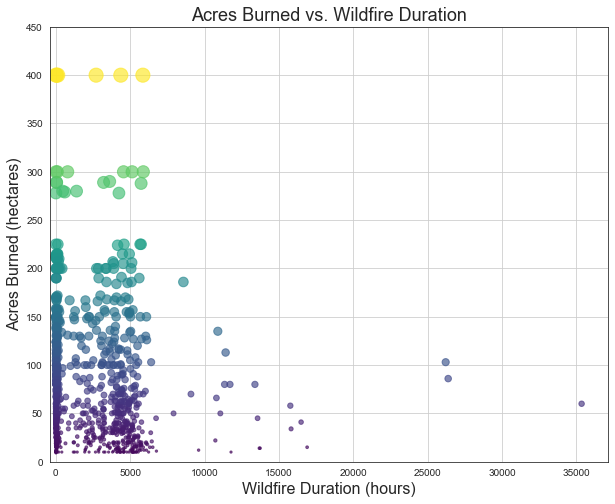

In [18]:
# Plot - Size - Area Burned
smallfires.plot(kind = "scatter", x = "Duration", y = "AcresBurned", cmap = mpl.cm.get_cmap("viridis"), 
               s = smallfires["AcresBurned"]/2, c = smallfires["AcresBurned"], 
               alpha = 0.65, figsize = (10, 8), colorbar = False)
plt.title("Acres Burned vs. Wildfire Duration", fontsize = 18)
plt.xlabel("Wildfire Duration (hours)", fontsize = 16)
plt.ylabel("Acres Burned (hectares)", fontsize = 16)
plt.grid(True)
plt.yticks(np.arange(0, 451, 50))
plt.xticks(np.arange(0, 35001, 5000), np.arange(0, 35001, 5000))
plt.ylim(ymin = 0)
plt.xlim(xmin = -400)
plt.savefig(source+"Duration_Independence.png")

In [19]:
# Correlation 
smallfires[["Duration", "AcresBurned"]].corr() # -0.091 - Very small correlation shown almost no linear relation 

,Duration,AcresBurned
Duration,1.000000,-0.091256
AcresBurned,-0.091256,1.000000


In [20]:
# Null Hypothesis 

***Proofs***
* 1) Very low correlation 
* 2) Scatter plot does not suggest any relationship 
* 3) (T-Statistics)

## Step 2 - Show that exponential correlation does not work 
* Introduction to why iterations are used in our modelling methods

In [21]:
# Exponential model
x = np.arange(0, 10)
y = np.exp(x)

In [22]:
# Conclude with research 
# Only front part of the fire expands and not 
# the other parts

## Step 3 - Model explanation
* 1) Introduction to the model (Assumptions)
* 2) Working of the model (Using pictures)
* 3) Maximum value of 0.25

### The model is built on the primary fact that the duration of wildfire does not affect the land area burned. 


**Assumptions**
* 1) The fire can spread only to adjecent blocks of land through active fire places
* 2) Every active block of fire spreads to only one other block of fire
* 3) At the end of each turn, some blocks are put off due to the salient features in that area

There are a certain number of iterations that occur for each fire. These iterations do not depict time but rather depict the transfer of fire from one block to the other. At the end of each turn, fire at some blocks is put off. The rte at which these fires are put off is understood through the control rate. Control Rate is the parameter which suggests how much resistance there is to an exponential spread of fire. (This control is then predicted using the salient features which are then used to compute the land area burned) 

* The number of itertions is set to be constant for each fire. This allows to understand how different control rates affect land are burned.

In [23]:
# Working of the model
# Controls
control_rate = 0.15
n_iterations = 10

Ten iterations are taken as the highest land area burend is lower than 1024 - 2^10

In [24]:
# Running a model 
fire_locations = rate_control_model(20, 0.15)

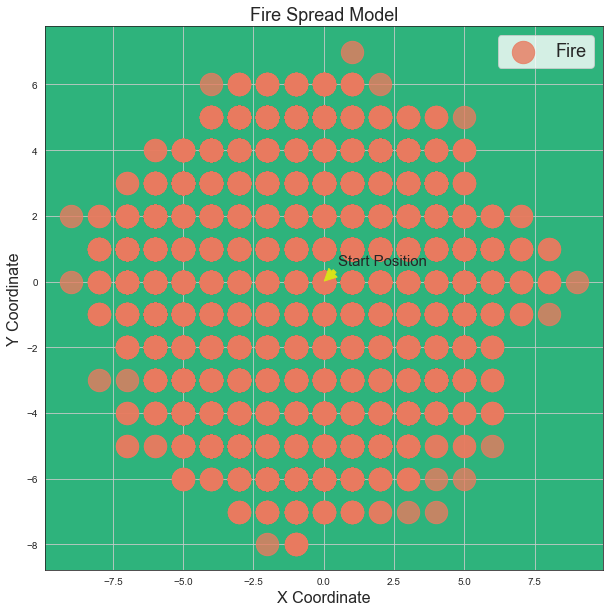

In [25]:
# Displaying the picture
plt.figure(figsize = (10,10))
ax = plt.gcf().gca()
ax.set_facecolor(mpl.cm.get_cmap('viridis')(11/17))
ax.scatter(fire_locations[:, 0], fire_locations[:, 1], color = mpl.cm.get_cmap('coolwarm')(14/17), 
           label = "Fire", s = 500, alpha = 0.8)
ax.set_title("Fire Spread Model", fontsize = 18)
ax.set_xlabel("X Coordinate", fontsize = 16)
ax.set_ylabel("Y Coordinate", fontsize = 16)

plt.annotate("Start Position", xycoords = "data", xy =[0.0, 0.0], 
             xytext = [0.5, 0.5], textcoords = "data",
            size = 15, arrowprops = {'shrink':0.04, "color":mpl.cm.get_cmap('viridis')(16/17)})
plt.legend(fontsize = 18)
plt.grid(True)
#plt.savefig(source+'FireSpreadModel.png')

In [26]:
# Total Acres burned 
total_burned = len(fire_locations)
print("Total Acres Burned: ", total_burned)

Total Acres Burned:  40666


In [27]:
# Acres burned

In [28]:
# Acres Burned vs. Control Rates
control_rates = np.linspace(0.0, 0.25, 25)
acres_burned = []
for rate in control_rates:
    locations = rate_control_model(10, float(rate))
    acres = len(locations)
    acres_burned.append(acres)

In [29]:
# Logger pro model preds
acres_burned= np.array(acres_burned)
acres_to_control_rates(acres_burned)

array([0.01541828, 0.01903155, 0.02469792, 0.02889783, 0.03843435,
       0.0473767 , 0.05237827, 0.07250334, 0.07927861, 0.08365374,
       0.09708271, 0.11185854, 0.1169207 , 0.15165324, 0.16369912,
       0.17442152, 0.18440436, 0.19200293, 0.1973988 , 0.19939652,
       0.20499018, 0.21339462, 0.21991316, 0.22436433, 0.23705501])

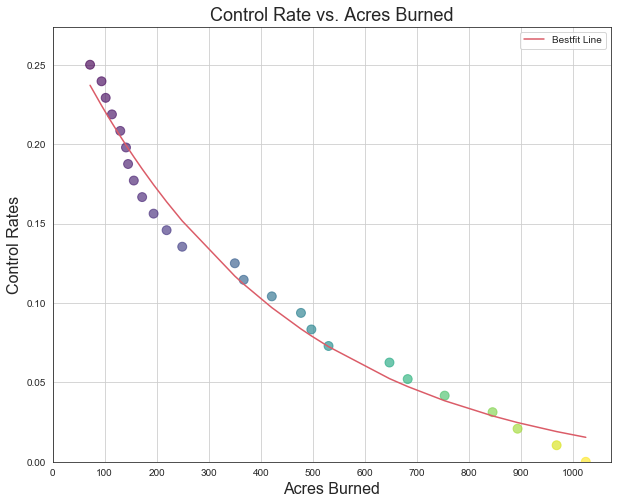

In [30]:
# Plotting the graph 
plt.figure(figsize = (10, 8))
plt.scatter(acres_burned, control_rates, cmap = mpl.cm.get_cmap('viridis'), s= 80, 
           c = acres_burned, alpha = 0.65)
plt.yticks(np.arange(0, 0.251, 0.05))
plt.xticks(np.arange(0, 1025, 100))

plt.ylabel("Control Rates", fontsize = 16)
plt.xlabel("Acres Burned", fontsize = 16)
plt.title("Control Rate vs. Acres Burned", fontsize = 18)
plt.plot(acres_burned,acres_to_control_rates(acres_burned), color = mpl.cm.get_cmap('plasma')(12/21), 
        label = "Bestfit Line")
plt.grid(True, axis= "both")
plt.legend()
plt.ylim(ymin = 0)
plt.xlim(xmin = 0)
plt.savefig(source+"ControlRate_vs_AcresBurned.jpg")

The value of control rate can not exceed 0.25 as the fire never starts to spread. So the range of values ranges from 0 to 0.25 . 
* 1) It can be observed that there is an inverse relation between Control Rates and the land area burned

### LoggerPro version of the model 
A logger pro model's predictions are noted down here using the function given below

In [31]:
def acres_to_control_rates(acres_array):
    """This function is built using logger pro and predicts the control rates
    given acres burned"""
    # COntrols
    A = 0.2933
    C = 0.0024
    B = -0.0097
    return A*np.exp(-C*acres_array)+B

In [32]:
# Alternate Version 
# Logger Pro
acres_burned = np.array(acres_burned)
# Creating a dataset with X and Y 
# This data will be analyzed in Logger Pro
Acres_to_Control = pd.DataFrame(np.c_[acres_burned, control_rates], columns =["LandBurned", "ControlRates"])
Acres_to_Control.head()

,LandBurned,ControlRates
0,1024.0,0.000000
1,968.0,0.010417
2,893.0,0.020833
3,845.0,0.031250
4,753.0,0.041667


In [33]:
Acres_to_Control.to_csv("Acres_to_Rates.csv", sep = ",")

In [34]:
# Exponential Decay graph 
# Controls 
A = 0.2933
C = 0.0024
B = -0.0097

In [35]:
control_rates_preds = A*np.exp(-C*acres_burned)+B

In [36]:
# Looking at the values
LoggerProPreds = acres_to_control_rates(AcresBurnedData)

In [37]:
# Model using Logger Pro
index = 180
random_rate = LoggerProPreds[index]
acres_predicted = calc_turns(10, random_rate)
print("Original Value: ", AcresBurnedData[index])
print("Model Predicted value: ", acres_predicted)

Original Value:  215.0
Model Predicted value:  172.0


In [38]:
acres_to_control_rates(np.array([1024]))

array([0.01541828])

## Step - 4 Approximation of the control rates using Acres Burned
The control rates are to be estimated using a fictional dataset. 

In [39]:
# Dataset 
y_control_rates = np.linspace(0.0, 0.25, 500)
X_acres_burned = []
for control_rate in y_control_rates:
    acres_burned = calc_turns(10, float(control_rate))
    X_acres_burned.append(acres_burned)
X_acres_burned = (np.array(X_acres_burned)).reshape(-1, 1)

In [40]:
# Training and validation set
from sklearn.model_selection import train_test_split
X_acres_train, X_acres_test, y_control_train, y_control_test = train_test_split(X_acres_burned, y_control_rates, test_size = 0.2)

In [41]:
# Model Selection 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(n_jobs = -1)
param_grid = {
    "n_estimators":np.arange(100, 120, 3),
    "max_leaf_nodes":np.arange(23, 27)
    
}
rfr_gs = GridSearchCV(rfr, param_grid, cv = 5, scoring = "neg_mean_squared_error")
results = rfr_gs.fit(X_acres_train, y_control_train)
best_acres_control = rfr_gs.best_estimator_

In [42]:
# Display results 
display_scores(results)

SCORE :  PARAMS
****************************************************************************************************
-2.7571670114797822e-06 : {'max_leaf_nodes': 26, 'n_estimators': 100}
-2.7665706487490377e-06 : {'max_leaf_nodes': 26, 'n_estimators': 112}
-2.767963222106822e-06 : {'max_leaf_nodes': 26, 'n_estimators': 109}
-2.803505514369848e-06 : {'max_leaf_nodes': 26, 'n_estimators': 103}
-2.837895195638489e-06 : {'max_leaf_nodes': 26, 'n_estimators': 118}
-2.8959955182307177e-06 : {'max_leaf_nodes': 26, 'n_estimators': 106}
-2.94300747727681e-06 : {'max_leaf_nodes': 25, 'n_estimators': 118}
-2.9691166719109497e-06 : {'max_leaf_nodes': 25, 'n_estimators': 106}
-3.0024762993253527e-06 : {'max_leaf_nodes': 26, 'n_estimators': 115}
-3.0285964435953795e-06 : {'max_leaf_nodes': 25, 'n_estimators': 115}
-3.0372001546801673e-06 : {'max_leaf_nodes': 25, 'n_estimators': 100}
-3.0524087201218098e-06 : {'max_leaf_nodes': 25, 'n_estimators': 109}
-3.064129311181372e-06 : {'max_leaf_nodes': 25, 

In [43]:
# Validation 
from sklearn.metrics import mean_squared_error
control_rate_error = mean_squared_error(y_control_test,best_acres_control.predict(X_acres_test))
print("The validation error: ", control_rate_error)

The validation error:  2.5466704691005246e-06


In [44]:
# Using the best estimator to pedict the Control Rates for the Dataset
AcresBurnedData = smallfires["AcresBurned"].to_numpy()
ControlRatesPreds = best_acres_control.predict(AcresBurnedData.reshape(-1, 1))

In [45]:
# Checking predictions and actual values
index = 76
random_rate = ControlRatesPreds[index]
acres_predicted = calc_turns(10, random_rate)
print("Original Value: ", AcresBurnedData[index])
print("Model Predicted value: ", acres_predicted)

Original Value:  25.0
Model Predicted value:  94.0


In [46]:
# Imputing on the DataSet
smallfires["ControlRates"] = 0
smallfires["ControlRates"] = ControlRatesPreds

In [47]:
smallfires.head()

,Latitude,Longitude,Duration,AcresBurned,Started,Date,DateIndex,ControlRates
39,34.200000,-117.417000,136.650000,200.0,2013-09-24 15:51:00+00:00,2013-09-24,266,0.153554
40,40.012398,-122.079871,3.000000,200.0,2013-07-04 07:30:00+00:00,2013-07-04,184,0.153554
43,38.382000,-122.311000,44.850000,190.0,2013-11-21 21:39:00+00:00,2013-11-21,324,0.154769
44,34.611824,-120.074655,19.100000,170.0,2013-05-28 15:24:00+00:00,2013-05-28,147,0.167508
48,38.345990,-122.650300,19.333333,159.0,2013-10-04 12:25:00+00:00,2013-10-04,276,0.174269


In [48]:
# The data has been placed according to the model 
# This model would help us predict the control rates given the AcresBurned

## Step 5 - Salient Features of California Dataset
* The aim of this step is to add the features to the Started date

In [49]:
# Salient Features of Conditions
salient_features = pd.read_csv('salient_features.csv', index_col = 0)

In [50]:
salient_features.head()

,MaxTemperature,AvgTemperature,MinTemerature,MaxDew Point,AvgDewPoint,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindSpeed,AvgWindSpeed,MinAvgSpeed,MaxPressure,AvgPressure,MinPressure
DateIndex,,,,,,,,,,,,,,,
0,53,47.1,42,40,36.7,34,82,67.7,54,17,7.7,0,30.3,30.2,30.2
1,54,45.8,37,44,35.8,31,83,69.1,49,7,2.5,0,30.2,30.2,30.1
2,53,46.0,38,42,37.2,33,83,71.6,63,3,1.1,0,30.3,30.2,30.2
3,54,47.8,42,42,38.1,35,82,69.5,55,7,2.5,0,30.3,30.2,30.2
4,53,49.2,42,48,43.7,36,93,82.0,76,10,3.5,0,30.3,30.1,30.1


In [51]:
# Renaming the columns 
renames = ["MaxTemperature",
"AvgTemperature",
"MinTemperature",
"MaxDewPoint",
"AvgDewPoint",
"MinDewPoint",
"MaxHumidity",
"AvgHumidity",
"MinHumidity",
"MaxWindSpeed",
"AvgWindSpeed",
"MinWindSpeed",
"MaxPressure",
"AvgPressure",
"MinPressure"]
columns =list(salient_features.columns)

res = {}
for index, original in enumerate(columns):
    res[str(original)]= renames[index]

salient_features = salient_features.rename(columns = res)

In [52]:
# Creating a dataframe with the required features
required_features = ["DateIndex", "Latitude", "Longitude", "AcresBurned", "ControlRates"]
dataframe_required = smallfires[required_features].copy()

# Reset Index
dataframe_required= dataframe_required.reset_index()

In [53]:
# Adding the columns 
# Creating New Columns 
for column_name in salient_features.columns:
    dataframe_required.loc[:, column_name] = 0

In [54]:
# Imputing the values
for index, DateIndex in enumerate(dataframe_required["DateIndex"]):
    try:
        RequiredSalientFeatures = (salient_features.iloc[DateIndex]).to_numpy()
        dataframe_required.loc[index, salient_features.columns] = RequiredSalientFeatures
    except IndexError:
        print(DateIndex)

In [55]:
dataframe_required.head()

,index,DateIndex,Latitude,Longitude,AcresBurned,ControlRates,MaxTemperature,AvgTemperature,MinTemperature,MaxDewPoint,...,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindSpeed,AvgWindSpeed,MinWindSpeed,MaxPressure,AvgPressure,MinPressure
0,39,266,34.200000,-117.417000,200.0,0.153554,69.0,62.9,58.0,54.0,...,50.0,78.0,67.8,54.0,33.0,18.9,7.0,30.0,29.9,29.9
1,40,184,40.012398,-122.079871,200.0,0.153554,76.0,67.1,59.0,57.0,...,45.0,80.0,61.2,45.0,26.0,13.2,0.0,29.8,29.7,29.7
2,43,324,38.382000,-122.311000,190.0,0.154769,61.0,54.8,50.0,49.0,...,0.0,94.0,67.1,34.0,25.0,9.6,0.0,30.0,29.9,29.9
3,44,147,34.611824,-120.074655,170.0,0.167508,64.0,58.8,55.0,54.0,...,49.0,88.0,76.7,62.0,23.0,11.5,3.0,30.0,30.0,29.9
4,48,276,38.345990,-122.650300,159.0,0.174269,75.0,69.1,62.0,51.0,...,28.0,53.0,38.6,21.0,16.0,9.1,0.0,30.1,30.0,30.0


In [56]:
# The imputation is complete 
# The data is to be divided into train, test and val set

## Step 6 - Preliminary Data Model
A preliminary model is created to look at the base line and next to help understand the feature importances

In [57]:
# X and y sets
X = (dataframe_required.loc[:, salient_features.columns]).copy()
y = (dataframe_required.loc[:, "ControlRates"]).copy()

In [58]:
# Standardization 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)

In [59]:
# Sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size = 0.2)

In [60]:
# Base model 
base_model = RandomForestRegressor(n_jobs = -1)
base_model.fit(X_train, y_train)
preds = base_model.predict(X_val)
base_error = mean_squared_error(preds, y_val)
print("The baseline error is: ", base_error) # 0.0009

The baseline error is:  0.0011103859291810615


In [61]:
base_model =SGDRegressor()
base_model.fit(X_train, y_train)
preds = base_model.predict(X_val)
base_error = mean_squared_error(preds, y_val)
print("The baseline error is: ", np.sqrt(base_error)) # 0.0009

The baseline error is:  0.031659740594089616


## Step 7 Feature Selection 
* Feature Selection using  - 1) Boxplots 2) Feature Importances

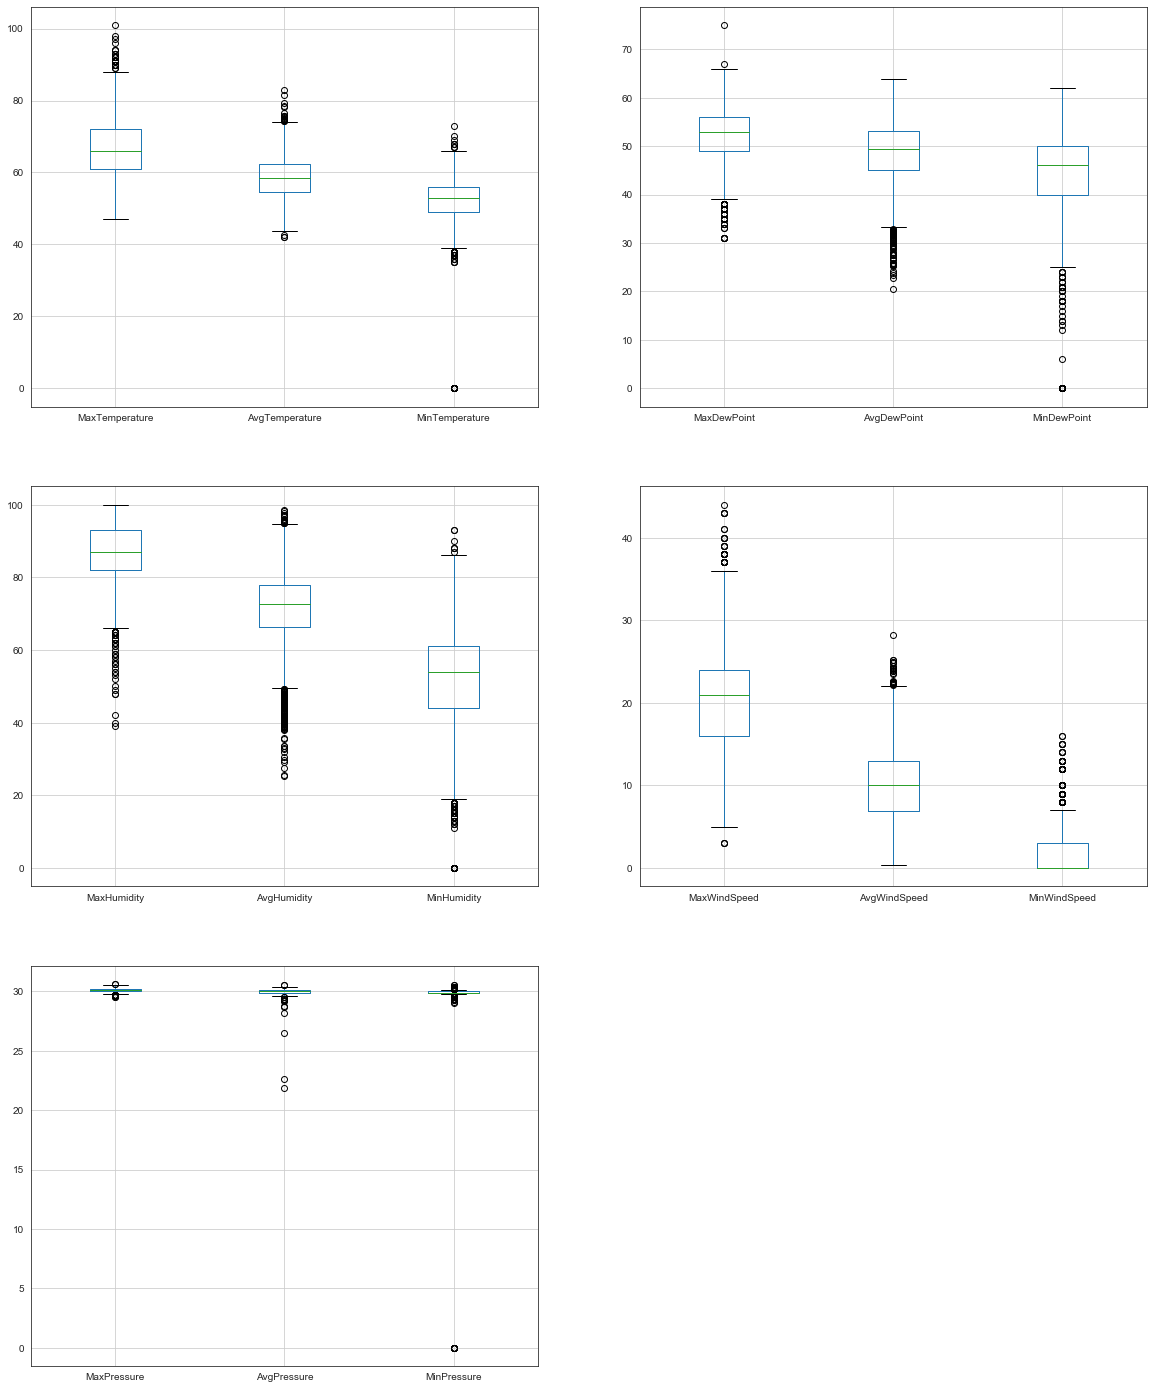

In [62]:
# Looking at the individual features using boxplots 
plt.figure(figsize=(20, 25))
names = ["Temperature", "DewPoint","Humidity","WindSpeed", "Pressure" ]
for index, i in enumerate(names):
    ax = plt.subplot(3, 2, index+1)
    s1 = ("Max"+i)
    s2 = ("Avg"+i)
    s3 = ("Min"+i)
    salient_features[[s1, s2, s3]].boxplot()
plt.savefig(source+"Boxplots.png")

In [63]:
# Feature Importances
#std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis = 0) # Deviation for each feature
#feature_importances = base_model.feature_importances_
#indices = np.argsort(feature_importances)[::-1]

In [64]:
# Bar plot
#plt.figure(figsize = (10, 8))
#plt.bar(list(salient_features.columns[indices]),feature_importances[indices]
#        ,yerr = std, color = mpl.cm.get_cmap("Blues_r")(0/8))
#plt.xticks(rotation = 90)
#plt.title("Feature Importances with standard deviation", fontsize = 20)
#plt.grid(True, axis = "y")
#plt.savefig(source+"Features_and_std.png")

* There are many different features which are important as seen from the figure. It is clear that some features are not important. The required features are - 

In [65]:
# Important Features are 
print("THE REQUIRED FEATURES are - ")
print("*"*50)
#for column_name in salient_features.columns[indices][:10]:
#    print(column_name)

THE REQUIRED FEATURES are - 
**************************************************


In [66]:
# Considering reqruied features
required_features = ["ControlRates", "AvgWindSpeed","AvgHumidity","AvgDewPoint","AvgTemperature","MaxHumidity",
"MaxTemperature","MaxWindSpeed","MinHumidity","MaxDewPoint","MinTemperature", "AvgPressure"]

In [67]:
# Looking at the Refined Dataset
refined_dataframe = dataframe_required[required_features].copy()

In [68]:
# The X and y 
X = refined_dataframe[["AvgWindSpeed","AvgHumidity","AvgDewPoint","AvgTemperature","MaxHumidity",
"MaxTemperature","MaxWindSpeed","MinHumidity","MaxDewPoint","MinTemperature"]].copy()
y = refined_dataframe["ControlRates"]

In [69]:
# Pf transform 
#from sklearn.preprocessing import PolynomialFeatures
#pf = PolynomialFeatures(degree =2)
#X = pf.fit_transform(X)

In [70]:
# Standardizing 
ss_final = StandardScaler()
X = ss_final.fit_transform(X)

In [71]:
# Training set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [72]:
# Grid Search 
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
param_grid = {
    "max_iter":np.arange(1050, 1200, 50),
    "eta0":np.linspace(2e-2, 4e-2, 100),
    
}
gs = GridSearchCV(sgd,param_grid, cv= 5, scoring = "neg_mean_squared_error")

In [73]:
# Running 
results = gs.fit(X_train, y_train)

In [74]:
# Displaying the scores
display_scores(results) # 0.000917

SCORE :  PARAMS
****************************************************************************************************
-0.0010647918994065094 : {'eta0': 0.025454545454545455, 'max_iter': 1100}
-0.0010652767455006126 : {'eta0': 0.02585858585858586, 'max_iter': 1150}
-0.0010662903858935392 : {'eta0': 0.02, 'max_iter': 1050}
-0.0010664962420580243 : {'eta0': 0.02383838383838384, 'max_iter': 1100}
-0.001066603881550622 : {'eta0': 0.027878787878787878, 'max_iter': 1100}
-0.0010672727580066314 : {'eta0': 0.037171717171717175, 'max_iter': 1100}
-0.001067792213940613 : {'eta0': 0.023434343434343436, 'max_iter': 1100}
-0.001067996414151151 : {'eta0': 0.0397979797979798, 'max_iter': 1050}
-0.001068031023892211 : {'eta0': 0.030505050505050507, 'max_iter': 1100}
-0.0010681378494841107 : {'eta0': 0.02707070707070707, 'max_iter': 1150}
-0.0010694026602551553 : {'eta0': 0.025050505050505052, 'max_iter': 1100}
-0.0010694316326449577 : {'eta0': 0.02707070707070707, 'max_iter': 1100}
-0.001069485683744623

## Step - 8 Error Comparison

In [75]:
# BEst model 
best_model = results.best_estimator_
best_model.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.025454545454545455, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1100,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [76]:
# Improvement in the model 
refined_preds = best_model.predict(X_val)
refined_error = mean_squared_error(refined_preds, y_val)
print("Validation Error: ", refined_error) # Error

Validation Error:  0.0007915599861688236


In [77]:
# Improvement 
print("Improvement percentage(%): ", (base_error -refined_error/base_error)*100)

Improvement percentage(%):  -78.87103711717802


In [125]:
print("Base model Error:", base_error)
print("Refined model Error:", refined_error)

Base model Error: 0.0010023391744850459
Refined model Error: 0.0007915599861688236


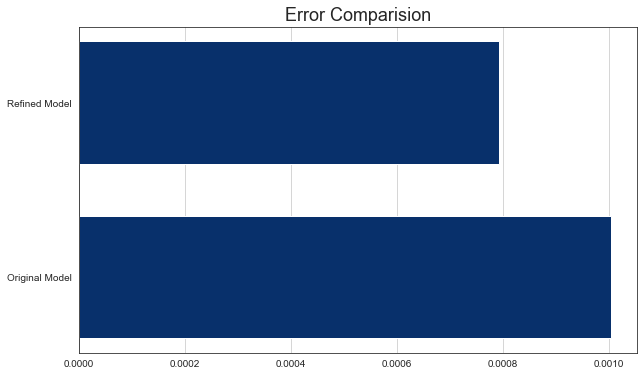

In [78]:
# Error Bar PLot 
plt.figure(figsize = (10, 6))
plt.barh(["Original Model", "Refined Model"], [base_error, refined_error], 
           color = mpl.cm.get_cmap("Blues_r")(0/8), height = 0.7)
plt.grid(axis = "x", which='major' )
plt.title("Error Comparision", fontsize = 18)
plt.savefig(source+"ErrorComparision.png")

## Step 9 - Use Model predictions to predict Acres Burned

### Test Predictions

In [79]:
X_total = np.append(X_train.copy(), X_val.copy(), axis = 0)
y_total = np.append(y_train.copy(), y_val.copy())

In [80]:
copy_dataframe_required = dataframe_required.copy()

In [81]:
non_zero_mask = (copy_dataframe_required["AcresBurned"] != 0)
selected_features = ["AvgWindSpeed","AvgHumidity","AvgDewPoint","AvgTemperature","MaxHumidity",
"MaxTemperature","MaxWindSpeed","MinHumidity","MaxDewPoint","MinTemperature"]

In [82]:
copy_dataframe_required

,index,DateIndex,Latitude,Longitude,AcresBurned,ControlRates,MaxTemperature,AvgTemperature,MinTemperature,MaxDewPoint,...,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindSpeed,AvgWindSpeed,MinWindSpeed,MaxPressure,AvgPressure,MinPressure
0,39,266,34.200000,-117.417000,200.0,0.153554,69.0,62.9,58.0,54.0,...,50.0,78.0,67.8,54.0,33.0,18.9,7.0,30.0,29.9,29.9
1,40,184,40.012398,-122.079871,200.0,0.153554,76.0,67.1,59.0,57.0,...,45.0,80.0,61.2,45.0,26.0,13.2,0.0,29.8,29.7,29.7
2,43,324,38.382000,-122.311000,190.0,0.154769,61.0,54.8,50.0,49.0,...,0.0,94.0,67.1,34.0,25.0,9.6,0.0,30.0,29.9,29.9
3,44,147,34.611824,-120.074655,170.0,0.167508,64.0,58.8,55.0,54.0,...,49.0,88.0,76.7,62.0,23.0,11.5,3.0,30.0,30.0,29.9
4,48,276,38.345990,-122.650300,159.0,0.174269,75.0,69.1,62.0,51.0,...,28.0,53.0,38.6,21.0,16.0,9.1,0.0,30.1,30.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,1317,2443,33.496633,-116.631106,10.0,0.245253,74.0,64.3,58.0,60.0,...,53.0,90.0,75.6,53.0,28.0,18.4,10.0,30.0,29.9,29.9
968,1318,2394,39.423833,-121.579738,10.0,0.245253,74.0,63.4,57.0,58.0,...,52.0,87.0,72.3,52.0,22.0,12.3,0.0,30.0,29.9,29.9
969,1319,2357,41.946220,-122.401570,10.0,0.245253,62.0,56.7,54.0,51.0,...,50.0,86.0,78.6,65.0,18.0,13.0,7.0,30.0,30.0,29.9
970,1320,2310,39.839580,-121.957000,10.0,0.245253,66.0,58.1,52.0,49.0,...,44.0,77.0,65.7,52.0,17.0,10.5,5.0,29.9,29.8,29.8


In [83]:
X = copy_dataframe_required[non_zero_mask][selected_features].copy()
pred_control_rates = copy_dataframe_required["ControlRates"]
y = pred_control_rates.copy()[non_zero_mask]

In [84]:
# Standardization 
ss_final = StandardScaler()
X = ss_final.fit_transform(X)

In [85]:
# Using pf
#X = pf.transform(X)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [87]:
# Using the same parameters to train over the entire data set
sgd_model = results.best_estimator_
sgd_model.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.025454545454545455, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1100,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [88]:
X_test.shape, X_val.shape

((238, 10), (156, 10))

In [89]:
# Prediction on test
test_preds = sgd_model.predict(X_test)
test_error = mean_squared_error(test_preds, y_test)
print("Test Error: ", test_error)

Test Error:  0.000923397804986133


In [90]:
# Using the test preds to look at the Acres Burned 
AcresBurned_test = []
for rate_control in test_preds:
    if float(rate_control)<0.25:
        AcresBurned_test_ind = calc_turns(10, float(rate_control))
        #print(AcresBurned_test_ind)
        AcresBurned_test.append(AcresBurned_test_ind)
    else:
        AcresBurned_test_ind = calc_turns(10, float(rate_control))
        #print(AcresBurned_test_ind)
        AcresBurned_test.append(AcresBurned_test_ind)

In [91]:
actual_acres = []
for index in list(y_test.index):
    actual_acres.append(dataframe_required.loc[index, "AcresBurned"])

In [92]:
from sklearn.metrics import mean_absolute_error
print("Mean Squared Error: ", mean_squared_error(AcresBurned_test, actual_acres))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(AcresBurned_test, actual_acres)))
print("Mean Absolute Error: ", mean_absolute_error(AcresBurned_test, actual_acres))

Mean Squared Error:  4843.676470588235
Root Mean Squared Error:  69.5965262824822
Mean Absolute Error:  60.239495798319325


The final Error is about 60.0 in Mean Absolute Error while the root mean squared error is about 71.7 . This makes the model pretty efficient is prediciting the land lost due to wildfire with upto a considerable degree of accuracy. This makes it possible to input value of Salient features such as - 
* 1) Humidity
* 2) Pressure 
* 3) WindSpeed
* 4) DewPoint 
* 5) Temperature

In [93]:
# The coefficients and the intercept are - 
for coef, column_name in zip(sgd_model.coef_, selected_features):
    print(column_name, ":", coef)

AvgWindSpeed : 0.002366169903785173
AvgHumidity : 0.004162106071811791
AvgDewPoint : -0.0008362249659804824
AvgTemperature : 0.0004946408109925242
MaxHumidity : 0.000699539169908545
MaxTemperature : 0.006527844320864143
MaxWindSpeed : -0.0029104384910406977
MinHumidity : -0.0007685626424774851
MaxDewPoint : -0.004854906111326643
MinTemperature : 0.0013858625439691513


In [94]:
# Sorting the features
selected_indices = np.argsort(sgd_model.coef_)[::-1]

In [95]:
[selected_indices],

([array([5, 1, 0, 9, 4, 3, 7, 2, 6, 8], dtype=int64)],)

In [96]:
sgd_model.coef_

array([ 0.00236617,  0.00416211, -0.00083622,  0.00049464,  0.00069954,
        0.00652784, -0.00291044, -0.00076856, -0.00485491,  0.00138586])

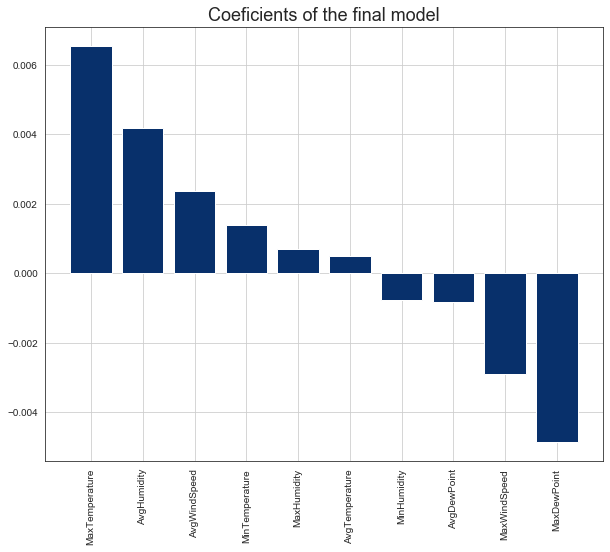

In [97]:
# Coefs Bar plot 
plt.figure(figsize = (10, 8))
plt.bar(pd.Series(selected_features)[selected_indices], np.array(sgd_model.coef_)[selected_indices], 
       color = mpl.cm.get_cmap("Blues_r")(0/8))
plt.xticks(rotation = 90)
plt.title("Coeficients of the final model", fontsize = 18)
plt.grid(True)
plt.savefig(source+"CoeficientsofModel.png")

In [98]:
# The intercept 
print("Intercept: ", sgd_model.intercept_ )

Intercept:  [0.22852235]


### Finding out the best model 

In [99]:
# Grid Search 
from sklearn.model_selection import GridSearchCV
sgd_final  = SGDRegressor()
param_grid_final = {
    "max_iter":np.arange(900, 1300, 10), 
    "eta0":np.linspace(1e-2, 1e-4, 10), 
    "tol":np.linspace(1e-5, 1e-2, 5)
}
gs_final = GridSearchCV(sgd_final, param_grid_final, cv = 5, scoring = "neg_mean_squared_error", n_jobs= -1)

In [100]:
# Running search 
results = gs_final.fit(X_train, y_train)

In [101]:
# Displaying scores
display_scores(results)

SCORE :  PARAMS
****************************************************************************************************
-0.0010375448149480798 : {'eta0': 0.01, 'max_iter': 1210, 'tol': 0.0075025000000000005}
-0.0010384955112979996 : {'eta0': 0.0078, 'max_iter': 920, 'tol': 0.005005}
-0.0010401550187065264 : {'eta0': 0.01, 'max_iter': 1080, 'tol': 0.0025075}
-0.0010410527116751212 : {'eta0': 0.01, 'max_iter': 1290, 'tol': 0.01}
-0.0010412543143779123 : {'eta0': 0.01, 'max_iter': 1250, 'tol': 0.01}
-0.0010413195236754075 : {'eta0': 0.01, 'max_iter': 980, 'tol': 0.0075025000000000005}
-0.0010413440439413287 : {'eta0': 0.0078, 'max_iter': 1120, 'tol': 1e-05}
-0.0010413893929138874 : {'eta0': 0.01, 'max_iter': 1010, 'tol': 1e-05}
-0.0010414321757350312 : {'eta0': 0.01, 'max_iter': 1060, 'tol': 0.0075025000000000005}
-0.0010415365515516783 : {'eta0': 0.01, 'max_iter': 1150, 'tol': 0.0025075}
-0.0010415811272018647 : {'eta0': 0.0089, 'max_iter': 1280, 'tol': 0.005005}
-0.001041798425134109 : {'e

-0.0010477527147168542 : {'eta0': 0.01, 'max_iter': 940, 'tol': 0.01}
-0.0010477538744050603 : {'eta0': 0.0078, 'max_iter': 1010, 'tol': 0.005005}
-0.001047773759010908 : {'eta0': 0.0078, 'max_iter': 1250, 'tol': 0.0025075}
-0.0010477745101658636 : {'eta0': 0.0078, 'max_iter': 1010, 'tol': 0.0025075}
-0.001047791702212603 : {'eta0': 0.0067, 'max_iter': 1050, 'tol': 1e-05}
-0.0010477922142814087 : {'eta0': 0.0089, 'max_iter': 1040, 'tol': 0.01}
-0.0010478000067111793 : {'eta0': 0.0089, 'max_iter': 1070, 'tol': 0.0025075}
-0.0010478092657384996 : {'eta0': 0.0078, 'max_iter': 930, 'tol': 0.0025075}
-0.001047822431387519 : {'eta0': 0.0089, 'max_iter': 950, 'tol': 0.01}
-0.001047829988055145 : {'eta0': 0.0089, 'max_iter': 1220, 'tol': 0.0025075}
-0.0010478355361253668 : {'eta0': 0.0045, 'max_iter': 1010, 'tol': 1e-05}
-0.0010478356682576894 : {'eta0': 0.0067, 'max_iter': 900, 'tol': 1e-05}
-0.001047855598504303 : {'eta0': 0.01, 'max_iter': 1220, 'tol': 0.005005}
-0.0010478734930881855 : {'e

-0.001055916294422465 : {'eta0': 0.0067, 'max_iter': 1180, 'tol': 0.0075025000000000005}
-0.0010559975723781789 : {'eta0': 0.0078, 'max_iter': 1180, 'tol': 0.01}
-0.0010560036165656213 : {'eta0': 0.0067, 'max_iter': 1040, 'tol': 0.0025075}
-0.001056027801213141 : {'eta0': 0.01, 'max_iter': 1170, 'tol': 0.01}
-0.001056235856417741 : {'eta0': 0.0067, 'max_iter': 1230, 'tol': 0.0025075}
-0.0010562654631463134 : {'eta0': 0.0067, 'max_iter': 1070, 'tol': 0.005005}
-0.0010562694474652184 : {'eta0': 0.0067, 'max_iter': 1140, 'tol': 0.0025075}
-0.0010563074444903725 : {'eta0': 0.0078, 'max_iter': 980, 'tol': 0.0075025000000000005}
-0.0010563962124611925 : {'eta0': 0.0078, 'max_iter': 1210, 'tol': 0.01}
-0.001056443546521501 : {'eta0': 0.0067, 'max_iter': 1250, 'tol': 0.005005}
-0.0010564832426662658 : {'eta0': 0.0067, 'max_iter': 910, 'tol': 0.0075025000000000005}
-0.00105648757715911 : {'eta0': 0.0067, 'max_iter': 1220, 'tol': 0.0025075}
-0.0010565591524458698 : {'eta0': 0.0078, 'max_iter': 9

-0.0013078536017325458 : {'eta0': 0.0045, 'max_iter': 1140, 'tol': 0.01}
-0.0013079020145173967 : {'eta0': 0.0045, 'max_iter': 1130, 'tol': 0.01}
-0.001308043365155641 : {'eta0': 0.0045, 'max_iter': 1270, 'tol': 0.01}
-0.0013080574877994701 : {'eta0': 0.0045, 'max_iter': 1220, 'tol': 0.01}
-0.0013083118872377942 : {'eta0': 0.0045, 'max_iter': 1210, 'tol': 0.01}
-0.0013089594529976094 : {'eta0': 0.0045, 'max_iter': 1090, 'tol': 0.01}
-0.001309048118376082 : {'eta0': 0.0045, 'max_iter': 1110, 'tol': 0.01}
-0.0013095895644572278 : {'eta0': 0.0045, 'max_iter': 1030, 'tol': 0.01}
-0.0013096439326978223 : {'eta0': 0.0045, 'max_iter': 1000, 'tol': 0.01}
-0.0013098551224657931 : {'eta0': 0.0045, 'max_iter': 1120, 'tol': 0.01}
-0.0013101103215713646 : {'eta0': 0.0045, 'max_iter': 910, 'tol': 0.01}
-0.001310273299737817 : {'eta0': 0.0045, 'max_iter': 900, 'tol': 0.01}
-0.0013102895577028278 : {'eta0': 0.0045, 'max_iter': 1060, 'tol': 0.01}
-0.0013103570620992384 : {'eta0': 0.0045, 'max_iter': 93

-0.013805022702702407 : {'eta0': 0.0011999999999999997, 'max_iter': 1030, 'tol': 0.01}
-0.013805116361149672 : {'eta0': 0.0011999999999999997, 'max_iter': 1240, 'tol': 0.0075025000000000005}
-0.01380571384941984 : {'eta0': 0.0011999999999999997, 'max_iter': 1100, 'tol': 0.01}
-0.013806202294853053 : {'eta0': 0.0011999999999999997, 'max_iter': 980, 'tol': 0.0075025000000000005}
-0.013806260368245924 : {'eta0': 0.0011999999999999997, 'max_iter': 1070, 'tol': 0.0075025000000000005}
-0.01380665849322912 : {'eta0': 0.0011999999999999997, 'max_iter': 1080, 'tol': 0.0075025000000000005}
-0.013806697071465293 : {'eta0': 0.0011999999999999997, 'max_iter': 900, 'tol': 0.01}
-0.013807140552100436 : {'eta0': 0.0011999999999999997, 'max_iter': 1250, 'tol': 0.0075025000000000005}
-0.01380747697126038 : {'eta0': 0.0011999999999999997, 'max_iter': 990, 'tol': 0.01}
-0.013807529987939516 : {'eta0': 0.0011999999999999997, 'max_iter': 1240, 'tol': 0.01}
-0.013807755911568595 : {'eta0': 0.0011999999999999

In [102]:
# best estimator 
be_final = results.best_estimator_
be_final.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1210,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.0075025000000000005, validation_fraction=0.1,
             verbose=0, warm_start=False)

In [103]:
# Predicitng using the best estimator
test_final_preds = be_final.predict(X_test)
print("RMSE Control Rates: ", np.sqrt(mean_squared_error(test_final_preds, y_test)))

RMSE Control Rates:  0.030567648943820493


In [104]:
# Predicting final acres burned 
AcresBurned_test = []
for rate_control in test_final_preds:
    if float(rate_control)<0.25:
        AcresBurned_test_ind = calc_turns(10, float(rate_control))
        AcresBurned_test.append(AcresBurned_test_ind)
    else:
        AcresBurned_test_ind = calc_turns(10, float(rate_control))
        AcresBurned_test.append(AcresBurned_test_ind)

In [105]:
# Actual Acres
actual_acres = []
for index in list(y_test.index):
    actual_acres.append(dataframe_required.loc[index, "AcresBurned"])

In [106]:
# RMSE in acres burned
print("Mean Squared Error: ", mean_squared_error(AcresBurned_test, actual_acres))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(AcresBurned_test, actual_acres)))
print("Mean Absolute Error: ", mean_absolute_error(AcresBurned_test, actual_acres))

Mean Squared Error:  4841.180672268908
Root Mean Squared Error:  69.57859349159702
Mean Absolute Error:  60.34033613445378


In [107]:
selected_indices = np.argsort(be_final.coef_)[::-1]

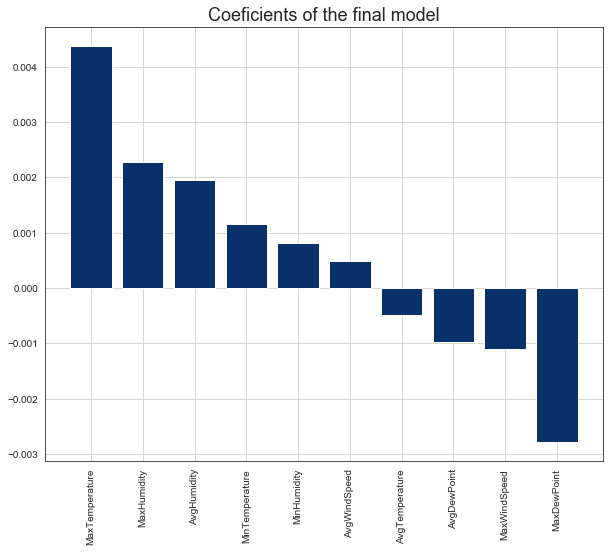

In [108]:
plt.figure(figsize = (10, 8))
plt.bar(pd.Series(selected_features)[selected_indices], np.array(be_final.coef_)[selected_indices], 
       color = mpl.cm.get_cmap("Blues_r")(0/8))
plt.xticks(rotation = 90)
plt.title("Coeficients of the final model", fontsize = 18)
plt.grid(True)
plt.savefig(source+"CoeficientsofModel.png")

In [109]:
# Final Equation 
string = "ControlRate = "
for coeff, name in zip(be_final.coef_, selected_features):
    string = string+str(round(coeff, 4))+"*("+name+") +"
string += str(round(be_final.intercept_[0], 4))

In [110]:
print(string)

ControlRate = 0.0005*(AvgWindSpeed) +0.0019*(AvgHumidity) +-0.001*(AvgDewPoint) +-0.0005*(AvgTemperature) +0.0023*(MaxHumidity) +0.0044*(MaxTemperature) +-0.0011*(MaxWindSpeed) +0.0008*(MinHumidity) +-0.0028*(MaxDewPoint) +0.0012*(MinTemperature) +0.2288


## Step - 10 Evaluation 
* 1) Strengths
* 2) Weaknesses
* 3) Further investigation
* 4) Future Exlorations
* 5) Questioning assumptions

* **Weaknesses**
* 1) It only generalizes to the climate and weather conditions of the state of California
* 2) It can not predict effectively in extreme weather conditions 

## Step 11 - Visualizations

### 1) Learning Rate

In [111]:
errors = []
for train_size in range(1, len(X_train)):
    train_set_X, train_set_y = X_train[:train_size], y_train[:train_size]
    sgd_lr = SGDRegressor(max_iter = 1000)
    sgd_lr.fit(train_set_X,train_set_y)
    test_preds = sgd_lr.predict(X_test)
    error = mean_squared_error(test_preds, y_test)
    errors.append(np.sqrt(error))

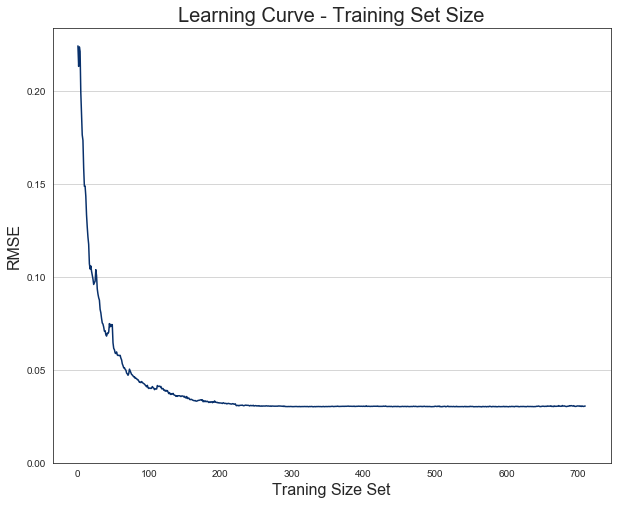

In [112]:
plt.figure(figsize =(10, 8))
plt.plot(np.arange(1, len(X_train)), errors, color = mpl.cm.get_cmap("Blues_r")(0/8))
plt.title("Learning Curve - Training Set Size", fontsize = 20)
plt.ylabel("RMSE", fontsize = 16)
plt.xlabel("Traning Size Set", fontsize = 16)
plt.grid(True, axis = "y")
plt.ylim(ymin = 0)
plt.savefig(source+"LearningCurve.png")

### 2) Contour

### 2) Feature Importances Pie Chart

In [145]:
X = (dataframe_required.loc[:, salient_features.columns]).copy()
y = (dataframe_required.loc[:, "ControlRates"]).copy()

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size = 0.2)

In [147]:
from sklearn.ensemble import RandomForestRegressor
rf_feature_importances = RandomForestRegressor()
rf_feature_importances.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [148]:
# Feature importances
feature_importances = rf_feature_importances.feature_importances_

In [149]:
salient_features.columns

Index(['MaxTemperature', 'AvgTemperature', 'MinTemperature', 'MaxDewPoint',
       'AvgDewPoint', 'MinDewPoint', 'MaxHumidity', 'AvgHumidity',
       'MinHumidity', 'MaxWindSpeed', 'AvgWindSpeed', 'MinWindSpeed',
       'MaxPressure', 'AvgPressure', 'MinPressure'],
      dtype='object')

In [150]:
# Sorting feature importances
sort_indices = np.argsort(feature_importances)[::-1]

In [151]:
donut_df = pd.DataFrame(feature_importances[sort_indices], columns = ["Importances"])

In [152]:
donut_df["Features"] = salient_features.columns[sort_indices]

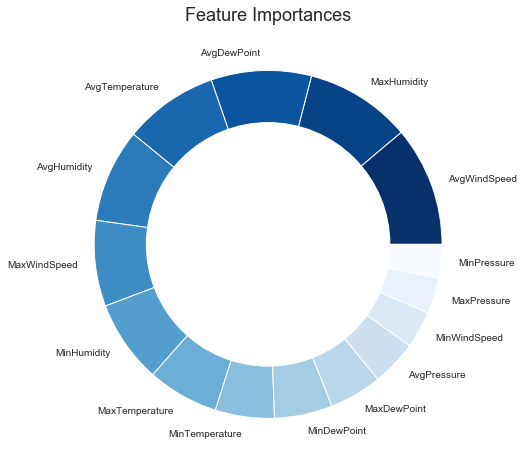

In [153]:
donut_df.plot(kind = "pie", y = "Importances", cmap = "Blues_r", 
             labels = donut_df["Features"], figsize = (10, 8), subplots = True)
plt.ylabel("")
circle = plt.Circle((0, 0), 0.7, color = "white")
ax = plt.gcf().gca()
legend = ax.get_legend()
legend.remove()

ax.add_artist(circle)

plt.title("Feature Importances", fontsize = 18)
plt.savefig(source+"FeatureImportancesPieChart.png")

In [154]:
selected_colors = []
cmap_selected = mpl.cm.get_cmap('Blues_r')
for color_index in range(15):
    if color_index >= 10:
        selected_colors.append(cmap_selected(3/4))
    else:
        selected_colors.append(cmap_selected(0/4))

In [155]:
len(selected_colors)

15

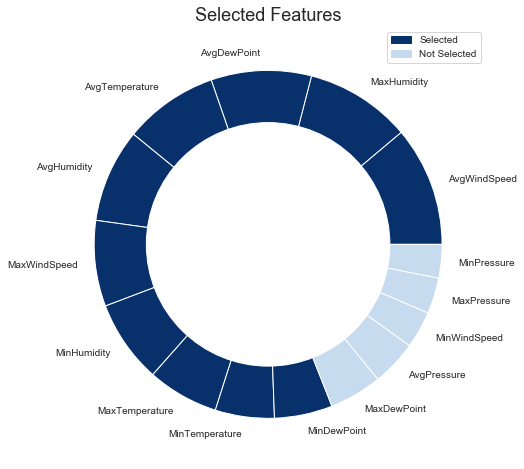

In [156]:
# Selected Features
donut_df.plot(kind = "pie", y = "Importances",  
             labels = donut_df["Features"], figsize = (10, 8), subplots = True, 
             colors = selected_colors)
plt.ylabel("")
circle = plt.Circle((0, 0), 0.7, color = "white")
ax = plt.gcf().gca()
legend = ax.get_legend()
legend.remove()

ax.add_artist(circle)

plt.title("Selected Features", fontsize = 18)

# Legend
import matplotlib.patches as mpatches
dark_blue = mpatches.Patch(color=cmap_selected(0/4), label='Selected')
light_blue = mpatches.Patch(color = cmap_selected(3/4), label = "Not Selected")
plt.legend(handles=[dark_blue, light_blue], loc = "upper right")
plt.savefig(source+"SelectedFeatures.png")

## 12) Datapoints

### Time Duration

In [157]:
# Time duration 
smallfires[["AcresBurned", "Duration"]].head() # hours

,AcresBurned,Duration
39,200.0,136.650000
40,200.0,3.000000
43,190.0,44.850000
44,170.0,19.100000
48,159.0,19.333333


### Fake Dataset

In [116]:
# Fake Dataset
fake_indices = np.random.randint(0, 500, 5)
fake_dataset = pd.DataFrame(X_acres_burned[fake_indices], columns = ["AcresBurned"] )
fake_dataset["ControlRates"] = y_control_rates[fake_indices]
fake_dataset

,AcresBurned,ControlRates
0,219,0.144790
1,358,0.117234
2,171,0.167836
3,488,0.086172
4,177,0.156814


### Logger Pro Coeffecieints and Equation 
* A = 0.2933
* C = 0.0024
* B = -0.0097
* Final Equation: ControlRate = A*(e^(-C X AcresBurned))+B

### Logger Pro Predictions 

In [117]:
logger_preds_indices = np.random.randint(0, len(AcresBurnedData), 5)
loggerpro_preds = pd.DataFrame(LoggerProPreds[logger_preds_indices], columns = ["ControlRatePredictions"])
loggerpro_preds["AcresBurned"] = AcresBurnedData[logger_preds_indices]

In [118]:
loggerpro_preds.head()

,ControlRatePredictions,AcresBurned
0,0.204990,130.0
1,0.274590,13.0
2,0.261918,32.0
3,0.272551,16.0
4,0.208627,123.0


### Selected Features Names

In [119]:
for name in selected_features:
    print(name)

AvgWindSpeed
AvgHumidity
AvgDewPoint
AvgTemperature
MaxHumidity
MaxTemperature
MaxWindSpeed
MinHumidity
MaxDewPoint
MinTemperature


### First Model Equation 

In [160]:
string = "ControlRate = "
for coef, name in zip(base_model.coef_, salient_features.columns):
    string += str(round(coef, 4))+"*("+name+") + "
string+= str(round(base_model.intercept_[0], 4))

In [161]:
print(string)

ControlRate = 0.0011*(MaxTemperature) + 0.0001*(AvgTemperature) + -0.003*(MinTemperature) + 0.0003*(MaxDewPoint) + -0.0005*(AvgDewPoint) + 0.0021*(MinDewPoint) + 0.0009*(MaxHumidity) + -0.001*(AvgHumidity) + -0.0009*(MinHumidity) + -0.0031*(MaxWindSpeed) + 0.0018*(AvgWindSpeed) + -0.0002*(MinWindSpeed) + -0.0009*(MaxPressure) + 0.001*(AvgPressure) + -0.0015*(MinPressure) + 0.2292


The baseline error is:  0.0359

### Refined Model

In [162]:
string = "ControlRate = "
for coef, name in zip(be_final.coef_, salient_features.columns):
    string += str(round(coef, 4))+"*("+name+") + "
string += str(round(be_final.intercept_[0], 4))

In [163]:
print(string)

ControlRate = 0.0005*(MaxTemperature) + 0.0019*(AvgTemperature) + -0.001*(MinTemperature) + -0.0005*(MaxDewPoint) + 0.0023*(AvgDewPoint) + 0.0044*(MinDewPoint) + -0.0011*(MaxHumidity) + 0.0008*(AvgHumidity) + -0.0028*(MinHumidity) + 0.0012*(MaxWindSpeed) + 0.2288


The refined Error:0.0357

In [ ]:
import os
os.environ['PATH'].split(';')

In [171]:
selected_features

['AvgWindSpeed',
 'AvgHumidity',
 'AvgDewPoint',
 'AvgTemperature',
 'MaxHumidity',
 'MaxTemperature',
 'MaxWindSpeed',
 'MinHumidity',
 'MaxDewPoint',
 'MinTemperature']

In [199]:
test_values = dataframe_required[:20]["AcresBurned"]
test_dataset = dataframe_required[:20][selected_features]

In [200]:
for i in range(len(test_dataset)):
    test_set = (test_dataset.iloc[i]).to_numpy()
    test_set = ss_final.transform(test_set.reshape(1, -1))
    test_control = be_final.predict(test_set)
    print(test_control, calc_turns(10, float(test_control)), test_values[i])
    

[0.22478478] 109 200.0
[0.22618748] 108 200.0
[0.22851384] 106 190.0
[0.22800061] 107 170.0
[0.22004442] 114 159.0
[0.23020872] 102 158.0
[0.22690972] 108 150.0
[0.2264124] 108 150.0
[0.22876251] 106 150.0
[0.22800061] 107 149.0
[0.23175706] 101 134.0
[0.22623843] 108 125.0
[0.22837543] 106 124.0
[0.22911976] 106 124.0
[0.22591866] 108 124.0
[0.2316318] 101 120.0
[0.2299436] 102 116.0
[0.22742261] 108 110.0
[0.22750281] 108 108.0
[0.22884575] 106 105.0


In [193]:
calc_turns

<function __main__.calc_turns(n_t, n_prob)>

In [174]:
be_final.predict(test_dataset)

array([0.69129801, 0.70103283, 0.69985138, 0.72244119, 0.61029967])

In [175]:
test_dataset

,AvgWindSpeed,AvgHumidity,AvgDewPoint,AvgTemperature,MaxHumidity,MaxTemperature,MaxWindSpeed,MinHumidity,MaxDewPoint,MinTemperature
0,18.9,67.8,51.9,62.9,78.0,69.0,33.0,54.0,54.0,58.0
1,13.2,61.2,52.9,67.1,80.0,76.0,26.0,45.0,57.0,59.0
2,9.6,67.1,39.9,54.8,94.0,61.0,25.0,34.0,49.0,50.0
3,11.5,76.7,51.4,58.8,88.0,64.0,23.0,62.0,54.0,55.0
4,9.1,38.6,42.5,69.1,53.0,75.0,16.0,21.0,51.0,62.0
